# Intrusion Detection Data Generation with GAN

## Install Dependencies and prepare Train, Test Sets

In [1]:
!pip install ctgan
!pip install table_evaluator
!pip install numpy
!pip install gdown
!pip install sdv
!pip install nbformat --upgrade
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from table_evaluator import TableEvaluator
import sdv

IPython not installed.


## Create Training Dataset and Categorical Columns

In [2]:
train_data = pd.read_csv('KDDTrain.csv')
normal_train_data = train_data.loc[train_data['label'].isin(['normal'])]
dos_train_data = train_data.loc[train_data['label'].isin(['dos'])]
probe_train_data = train_data.loc[train_data['label'].isin(['probe'])]
r2l_train_data = train_data.loc[train_data['label'].isin(['r2l'])]
u2r_train_data = train_data.loc[train_data['label'].isin(['u2r'])]
minority_train_data = train_data.loc[train_data['label'].isin(['u2r','r2l','probe' ])]

categorical_columns = [
    'protocol_type', 'service', 'flag', 'land', 'wrong_fragment', 'urgent',
    'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login', 
    'label'
]
print(train_data.shape[0])
print(minority_train_data.shape[0])

125973
12703


## Train and Save GAN Model With and Without PCA

In [6]:
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer
import matplotlib.pyplot as plt

def train_and_save_synthesizer(train_data, file_name, table_name='nsl-kdd-minority', epochs=2000, enforce_rounding=True, verbose=True):
    """
    Trains a CTGAN Synthesizer model on the provided training data, saves it to a file, and displays the training loss plot.

    Args:
        train_data (pandas.DataFrame): The training data to be used for synthesizing.
        file_name (str): The path where the trained model will be saved.
        table_name (str): Name of the table for metadata detection. Defaults to 'nsl-kdd-minority'.
        epochs (int): Number of training epochs. Defaults to 2000.
        enforce_rounding (bool): Whether to enforce rounding of the generated data. Defaults to False.
        verbose (bool): Whether to print progress during training. Defaults to True.
    """
    # Detect metadata from the training data
    metadata = Metadata.detect_from_dataframe(data=train_data, table_name=table_name)
    
    # Initialize the CTGAN synthesizer with the detected metadata
    synthesizer = CTGANSynthesizer(
        metadata=metadata,
        enforce_rounding=enforce_rounding,
        epochs=epochs,
        verbose=verbose
    )
    
    # Print the parameters used by the synthesizer (optional)
    print(synthesizer.get_parameters())
    
    # Fit the synthesizer to the training data
    synthesizer.fit(train_data)
    
    # Save the trained model to the specified file
    synthesizer.save(filepath=file_name)
    print(f'Model saved to {file_name}')
    
    # Generate and display the loss values plot
    fig = synthesizer.get_loss_values_plot()
    if fig:
        fig.show()
    else:
        print('No loss values plot available.')


In [7]:
train_and_save_synthesizer(minority_train_data, 'nsl-kdd-gan-minority.pkl')

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


{'enforce_min_max_values': True, 'enforce_rounding': True, 'locales': ['en_US'], 'embedding_dim': 128, 'generator_dim': (256, 256), 'discriminator_dim': (256, 256), 'generator_lr': 0.0002, 'generator_decay': 1e-06, 'discriminator_lr': 0.0002, 'discriminator_decay': 1e-06, 'batch_size': 500, 'discriminator_steps': 1, 'log_frequency': True, 'verbose': True, 'epochs': 2000, 'pac': 10, 'cuda': True}


Gen. (-1.30) | Discrim. (-0.26): 100%|██████████| 2000/2000 [1:04:13<00:00,  1.93s/it]


Model saved to nsl-kdd-gan-minority.pkl


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

def apply_pca(train_data, label_column, n_components):
    """
    Performs PCA on the training data (excluding the label column), selects relevant columns, and returns those columns 
    after handling categorical data, appending the label column back.

    Args:
        train_data (pandas.DataFrame): The training data to perform PCA on.
        label_column (str): The name of the label column to exclude from PCA.
        n_components (int): The number of principal components to keep.

    Returns:
        pandas.DataFrame: Transformed data after applying PCA with the label column appended.
        list: List of selected relevant columns (based on variance importance).
    """
    # Separate the label column
    labels = train_data[label_column]
    features = train_data.drop(columns=[label_column])
    
    # Separate categorical and numeric columns
    categorical_columns = features.select_dtypes(include=['object']).columns
    numeric_columns = features.select_dtypes(exclude=['object']).columns

    # Apply One-Hot Encoding to categorical columns
    encoder = OneHotEncoder(sparse=False, drop='first')  # 'drop=first' avoids multicollinearity
    encoded_categorical_data = encoder.fit_transform(features[categorical_columns])
    
    # Create a DataFrame for the encoded categorical data
    encoded_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_columns))
    
    # Combine encoded categorical data with the numeric data
    full_data = pd.concat([features[numeric_columns].reset_index(drop=True), encoded_df], axis=1)
    
    # Standardize the data before applying PCA
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(full_data)
    
    # Initialize the PCA model with the specified number of components
    pca = PCA(n_components=n_components)
    
    # Fit and transform the scaled data using PCA
    pca_result = pca.fit_transform(scaled_data)
    
    # Calculate the feature importance (explained variance ratio)
    importance = pca.components_.T * pca.explained_variance_ratio_
    
    # Identify the most relevant columns (features) by summing their absolute importance
    feature_importance = pd.DataFrame(importance, index=full_data.columns, columns=[f'PC{i+1}' for i in range(n_components)])
    feature_importance['total_importance'] = feature_importance.abs().sum(axis=1)
    
    # Sort the features by importance and select the top ones based on n_components
    selected_columns = feature_importance.sort_values('total_importance', ascending=False).index[:n_components].tolist()
    
    # Create a DataFrame for PCA-transformed data
    pca_transformed_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
    
    # Append the label column back to the transformed data
    pca_transformed_df[label_column] = labels.reset_index(drop=True)
    
    # Return the PCA-transformed data and selected relevant columns
    return pca_transformed_df, selected_columns


In [25]:
pca_transformed_data, selected_columns = apply_pca(minority_train_data, label_column='label', n_components=20)
print(f"Selected columns: {selected_columns}")
train_and_save_synthesizer(pca_transformed_data, 'nsl-kdd-gan-minority-pca.pkl')

/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



Selected columns: ['flag_REJ', 'dst_host_srv_rerror_rate', 'srv_rerror_rate', 'rerror_rate', 'protocol_type_tcp', 'service_private', 'service_eco_i', 'dst_host_same_src_port_rate', 'flag_SF', 'dst_host_rerror_rate', 'srv_diff_host_rate', 'count', 'service_other', 'dst_host_count', 'dst_host_srv_diff_host_rate', 'same_srv_rate', 'dst_host_same_srv_rate', 'flag_RSTR', 'diff_srv_rate', 'dst_host_diff_srv_rate']
{'enforce_min_max_values': True, 'enforce_rounding': True, 'locales': ['en_US'], 'embedding_dim': 128, 'generator_dim': (256, 256), 'discriminator_dim': (256, 256), 'generator_lr': 0.0002, 'generator_decay': 1e-06, 'discriminator_lr': 0.0002, 'discriminator_decay': 1e-06, 'batch_size': 500, 'discriminator_steps': 1, 'log_frequency': True, 'verbose': True, 'epochs': 2000, 'pac': 10, 'cuda': True}


/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/sdv/single_table/base.py:105: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Gen. (-0.72) | Discrim. (-0.71): 100%|██████████| 2000/2000 [28:46<00:00,  1.16it/s]

Model saved to nsl-kdd-gan-minority-pca.pkl


## Load and Run Saved GAN Model

In [27]:
from sdv.single_table import CTGANSynthesizer

loaded_synthesizer = CTGANSynthesizer.load(filepath='nsl-kdd-gan-minority.pkl')

In [28]:
from sdv.sampling import Condition

# Function to generate synthetic data and append to the CSV file
def generate_and_append_synthetic_data(csv_file, label, num_rows, synthesizer):
    # Load the existing CSV file
    df = pd.read_csv(csv_file)
    
    # Define the condition to generate synthetic data for the specified label
    condition = Condition(num_rows=num_rows, column_values={'label': label})
    
    # Generate synthetic data
    synthetic_data = synthesizer.sample_from_conditions(conditions=[condition])

    # Round all numeric columns to 2 decimal places
    synthetic_data = synthetic_data.round(2)
    
    # Concatenate the generated synthetic data with the original dataframe
    updated_df = pd.concat([df, synthetic_data], ignore_index=True)
    
    # Overwrite the original CSV file with the updated dataframe
    updated_df.to_csv(csv_file, index=False)
    
    print(f"Synthetic data for label '{label}' added to {csv_file}")

In [44]:
csv_file = 'KDDTrainSynthatic.CSV'
generate_and_append_synthetic_data(csv_file, 'u2r', 5000, loaded_synthesizer)
generate_and_append_synthetic_data(csv_file, 'r2l', 5000, loaded_synthesizer)
#generate_and_append_synthetic_data(csv_file, 'probe', 5000, loaded_synthesizer)

Sampling conditions: 100%|██████████| 5000/5000 [00:02<00:00, 1778.73it/s]


Synthetic data for label 'u2r' added to KDDTrainSynthatic.CSV


Sampling conditions: 100%|██████████| 5000/5000 [00:01<00:00, 3299.11it/s]


Synthetic data for label 'r2l' added to KDDTrainSynthatic.CSV


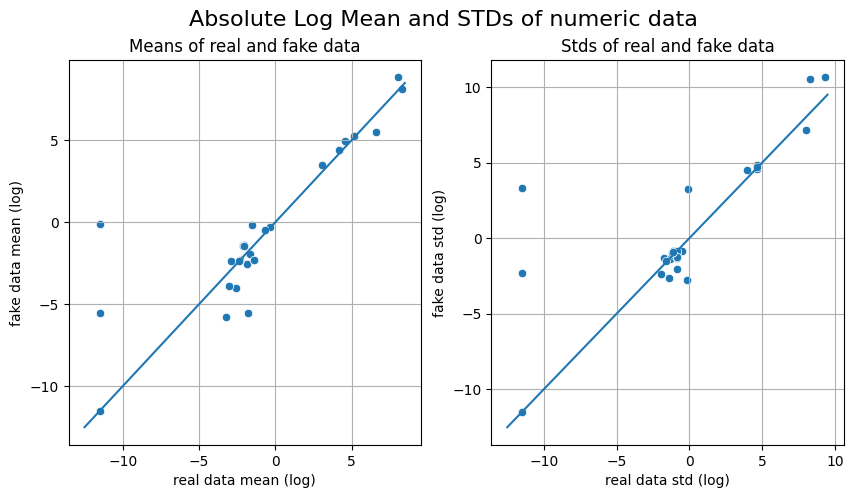

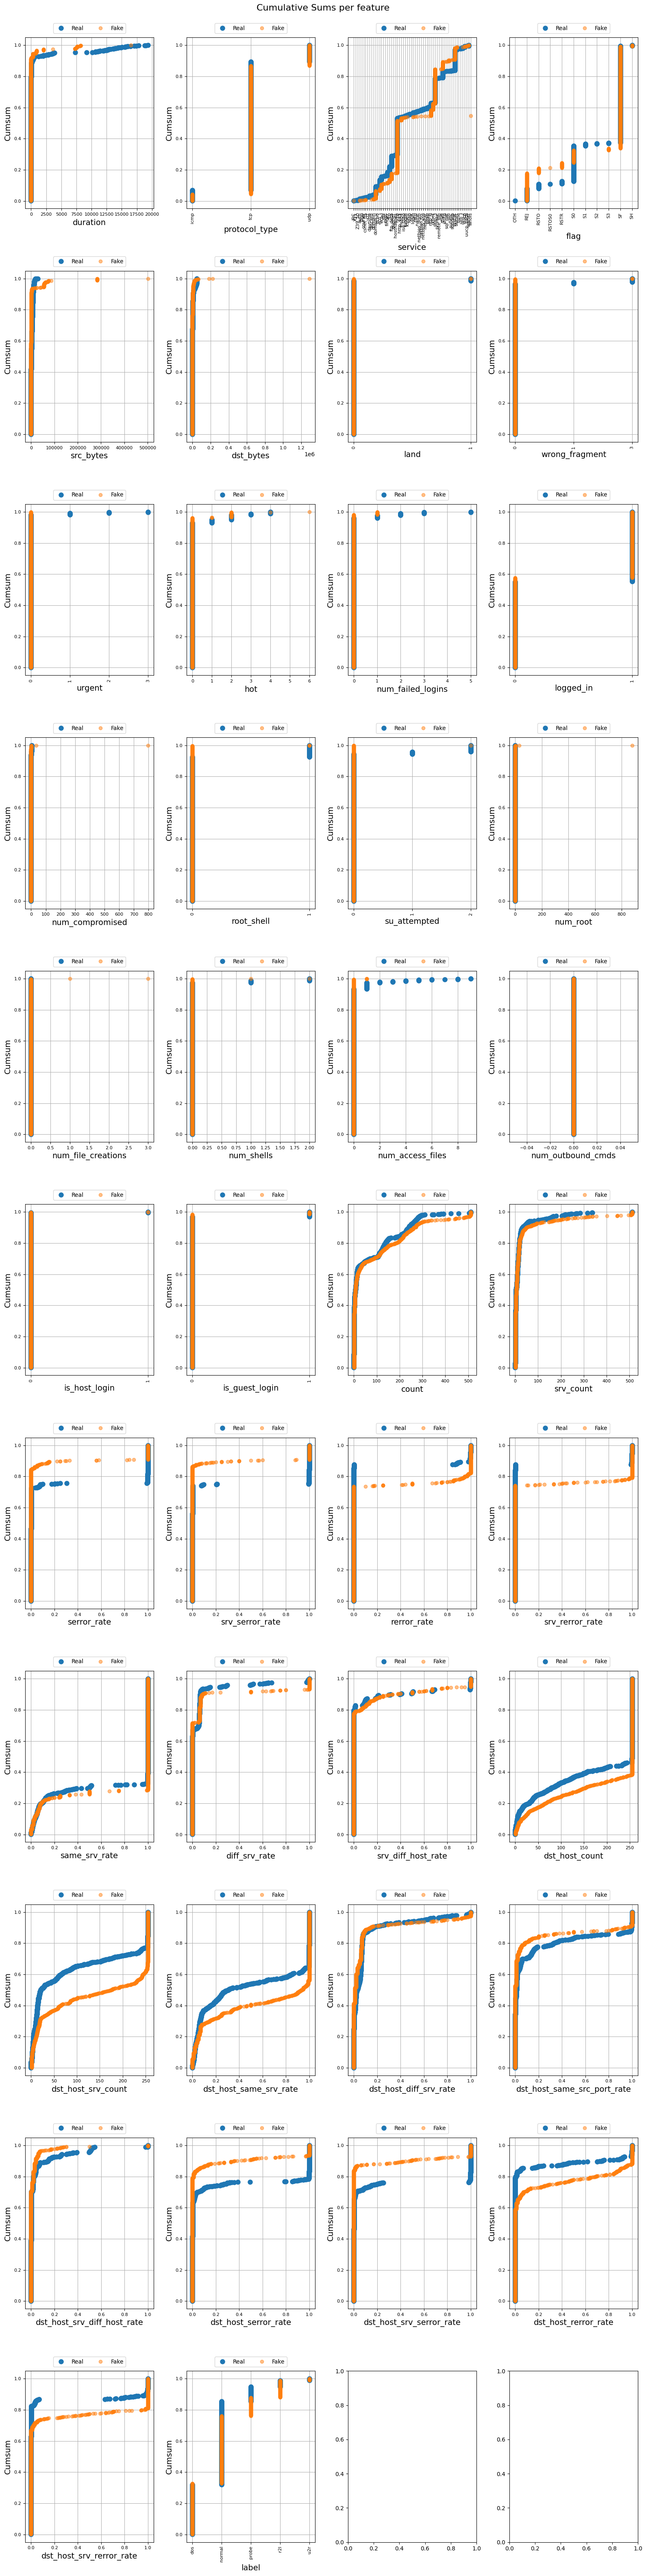

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
/opt/homebre

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

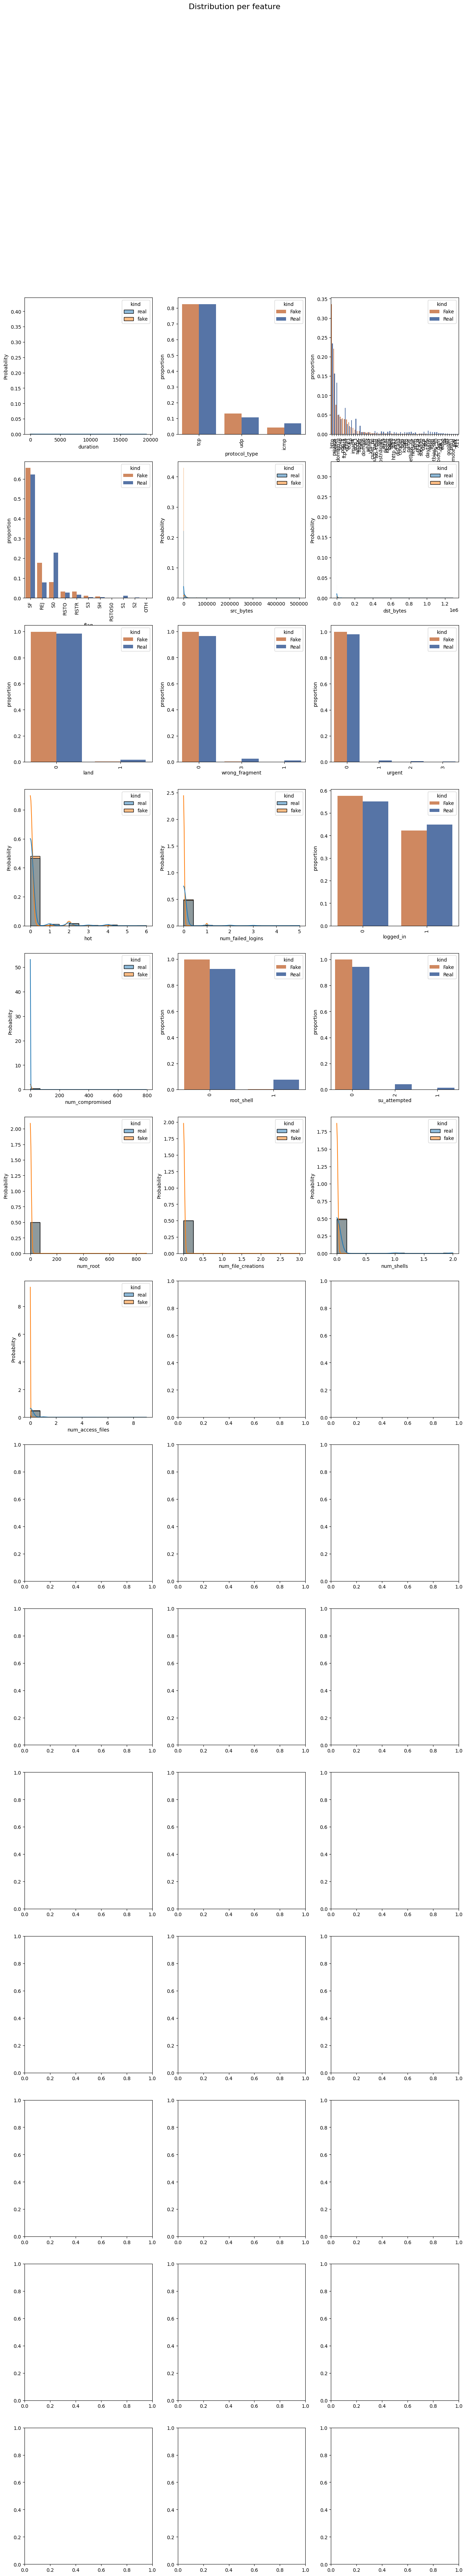

In [7]:
test_data = pd.read_csv('KDDTest.csv')
#train_data['value'] = pd.to_numeric(test_data['value'], errors='coerce')
#test_data['timestamp'] = pd.to_datetime(test_data['timestamp'], unit='ms')
#test_data['timestamp'] = test_data['timestamp'].astype(int) / 10**9

table_evaluator =  TableEvaluator(loaded_synthesizer.sample(1000), test_data, cat_cols= categorical_columns)

table_evaluator.visual_evaluation()